# Filtering Spam Using TFIDF and Logistic Regression

In this notebook I demonstrate the ability to filter emails into spam and ham using term frequency inverse document frequency (TFIDF) and a logistic regression classifier. This classifier patitions the corpus into four categories based on the true contents (spam or ham) an the difficulty of classification (truly or falsely correct classification). I originally intended to compare the TFIDF logistic classifier to a neural network trained on BERT vectorization of the email body, which is why chose to build this notebook on Google Colab, as my laptop does not have a GPU. I did successfully apply the BERT model to the text corpus and construct a neural network trainig pipeline. However due to time constraints I was unable to optimize the pipeline sufficiently to train the model to any degree. I have included some of the in-progress code at the bottom of this notebook for your interest, but do not try to run it as it will not work.

Here is a preview of today's tech.

In [1]:
import os, email
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
import torch
print(torch.__version__)
%pip install pytorch==1.6
%pip install -U sentence-transformers
%pip install ipywidgets --user

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthewtoles/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
1.7.1
ERROR: Could not find a version that satisfies the requirement pytorch==1.6
ERROR: No matching distribution found for pytorch==1.6
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Parse the data. Notice that there are 226 documents that do not use UTF-8, which we will omit from the dataset like last time.

In [2]:
def read_data(dirs):
  emails_df = pd.DataFrame()
  errors = 0
  #print("Files with errors:")
  for dir in dirs:
    path = os.path.join("./data/", dir)
    c = 1 if dir=='spam' else 0
    print("Extracting:", path)
    for root, dirs, files in os.walk(path):
      unhidden_files = [f for f in files if not f[0] == '.'] # Ignore hidden files

      # 226 files are not in UTF-8. I ignore them here as well
      for f in unhidden_files:
        path = os.path.join(root, f)
        try: # Ignore files not encoded in UTF-8
          message = email.message_from_file(open(path))
        except UnicodeDecodeError as e:
          errors += 1
          #if errors>10: break
        else:
          df_row = dict(message)
          df_row['Dir'] = root
          df_row['Filename'] = f
          df_row['Path'] = path # Will serve as primary key (index)
          df_row['Email'] = message
          df_row['Body'] = message.get_payload()
          df_row['Subject'] = message['subject']
          df_row['Class'] = c
          emails_df = emails_df.append(df_row, ignore_index=True)
  print('error count:', errors)
  emails_df = emails_df.set_index('Path')
  emails_df['Body'] = emails_df['Body'].astype('string')
  emails_df['Subject'] = emails_df['Subject'].astype('string')
  return emails_df

email_df = read_data(['ham', 'spam'])

Extracting: ./data/ham
Extracting: ./data/spam
error count: 0


KeyError: "None of ['Path'] are in the columns"

In [3]:
%debug

> /Users/matthewtoles/code/anaconda/anaconda3/envs/v37/lib/python3.7/site-packages/pandas/core/frame.py(4551)set_index()
   4549 
   4550         if missing:
-> 4551             raise KeyError(f"None of {missing} are in the columns")
   4552 
   4553         if inplace:

> <ipython-input-2-355744ede901>(31)read_data()
     29           emails_df = emails_df.append(df_row, ignore_index=True)
     30   print('error count:', errors)
---> 31   emails_df = emails_df.set_index('Path')
     32   emails_df['Body'] = emails_df['Body'].astype('string')
     33   emails_df['Subject'] = emails_df['Subject'].astype('string')

Empty DataFrame
Columns: []
Index: []
'./data/spam'
*** NameError: name 'pwd' is not defined
<module 'posixpath' from '/Users/matthewtoles/code/anaconda/anaconda3/envs/v37/lib/python3.7/posixpath.py'>
'/Users/matthewtoles/Downloads'
'/Users/matthewtoles/Downloads'


Construct train and test data sets

In [4]:
# Output: train and test x and y as single-column dataframes
# Seed for reproducable deterministic behavior
def get_data(df, seed=0):
  x_train, x_test, y_train, y_test = train_test_split(
      df[['Body', 'Subject']], # Retain Path column in X data for future investigation. Will not be used in inference.
      df['Class'], 
      test_size = 0.2, 
      random_state=seed
  )
  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_data(email_df[['Body', 'Subject', 'Class']])



Build vectorizers for the email subjects and email bodies of the x_train data set

In [5]:
# Input: vectorizer, single-column df (series)
# Output: dataframe of TFIDF features trained on df
def get_tfidf_vectorizer(df, y):
  from nltk.corpus import stopwords
  sw_list = stopwords.words('english')

  from sklearn.feature_extraction.text import TfidfVectorizer
  vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,1), stop_words=sw_list)

  tfidf_features = vectorizer.fit_transform(df, y)
  return vectorizer

tfidf_subject_vectorizer = get_tfidf_vectorizer(x_train['Subject'], y_train)
tfidf_body_vectorizer = get_tfidf_vectorizer(x_train['Body'], y_train)

x_train_subject_vectorized = tfidf_subject_vectorizer.transform(x_train['Subject'])
x_train_body_vectorized = tfidf_body_vectorizer.transform(x_train['Body'])



Concatentate the sparse matrix representations of the subject and body vectorizers. Then train a logistic classifier using the y_train labels.

In [6]:
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack

def get_log_classifier(x_features, y_train, hyperparameters={}):
  clf = LogisticRegression(**hyperparameters)
  clf.fit(x_features, y_train)    
  return clf

x_train_all_tfidf_vectorized = hstack((x_train_subject_vectorized, x_train_body_vectorized))

log_classifier = get_log_classifier(x_train_all_tfidf_vectorized, y_train)


test_input = hstack((tfidf_subject_vectorizer.transform(x_test['Subject']), tfidf_body_vectorizer.transform(x_test['Body'])))
log_classifier.score(test_input, y_test)



0.9603603603603603

Let's wrap it all up so that we can run a proper train-validation k-fold split so that we can save our test set for post-hyperparameter-tuning evaluation.

In [10]:
from sklearn.model_selection import KFold
k = 5
def score(kf_indices, hyperparameters={}):
  kf = KFold(n_splits=k)
  k_indices = list(kf.split(x_train)) # k, 4n/5, 1n/5 dim tensor
  for i in range(1):
    fold_train_ind = k_indices[i][0]
    fold_val_ind = k_indices[i][1]

    x_fold_train = x_train.iloc[fold_train_ind]
    x_fold_val = x_train.iloc[fold_val_ind]
    y_fold_train = y_train.iloc[fold_train_ind]
    y_fold_val = y_train.iloc[fold_val_ind]

    x_train_subject_vectorized = tfidf_subject_vectorizer.transform(x_fold_train['Subject'])
    x_train_body_vectorized = tfidf_body_vectorizer.transform(x_fold_train['Body'])
    x_train_all_tfidf_vectorized = hstack((x_train_subject_vectorized, x_train_body_vectorized))
    log_classifier = get_log_classifier(x_train_all_tfidf_vectorized, y_fold_train, hyperparameters)

    input = hstack((tfidf_subject_vectorizer.transform(x_fold_val['Subject']), tfidf_body_vectorizer.transform(x_fold_val['Body'])))

    scores = []
    score = log_classifier.score(input, y_fold_val)

    scores.append(score)
  return (sum(scores)/len(scores), log_classifier)



kf_indices = sklearn.model_selection.KFold(n_splits=k, random_state=0, shuffle=True)
hyperparameters = {
    'penalty': 'elasticnet',
    'solver': 'saga',
    'l1_ratio': 0.5,
}
print(score(kf_indices, hyperparameters)[0])




0.9121621621621622


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Great, our baseline accuracy is 91.22%. Now let's do some hyperparameter tuning with scikit-optimize. Random search is for n00bs. Don't even get me started on grid search.

Since inverse regularization strength parameter C operates on an exponential scale, we take the exponent of the optimization parameter before passing it to the model constructor.

You can set the number of iterations with the `n` parameter.

Now is a great time to go get a coffee.

In [11]:
!pip install 'scikit-optimize[plots]'

In [19]:
# Disable non-convergence warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


from skopt import Optimizer
import math

n = 100

def search_hyperparameters():
  hyp_mins = {
      'C': -4.0,
      'l1_ratio': 0.0,
  }

  hyp_maxs = {
      'C': 4.0,
      'l1_ratio': 1.0,
  }
  hypers = list(zip(hyp_mins.values(), hyp_maxs.values()))
  print(hypers)
  opt = Optimizer(hypers)
  max_y = -1
  best_model = None

  for i in range(n):
    suggested = opt.ask()
    payload = dict(zip(hyp_mins.keys(), suggested))
    payload['penalty'] = 'elasticnet'
    payload['solver'] = 'saga'
    payload['C'] = math.exp(payload['C'])
    y, last_model = score(kf_indices, payload)
    if y > max_y: 
      max_y = y
      best_model = last_model
      print('new best!')
    opt.tell(suggested, y)
    print('iteration:', i, suggested, y)
  return (max_y, best_model)

max_y, best_model = search_hyperparameters()

[(-4.0, 4.0), (0.0, 1.0)]
new best!
iteration: 0 [0.32191766614673245, 0.529502702241105] 0.9234234234234234
new best!
iteration: 1 [2.6263953335687145, 0.6455228509043494] 0.954954954954955
iteration: 2 [-0.9328893355947452, 0.1964079378066212] 0.8941441441441441
iteration: 3 [1.482898242830477, 0.6634428080859829] 0.9481981981981982
iteration: 4 [-2.816730049552877, 0.2928020861753526] 0.8378378378378378
iteration: 5 [-1.6997120300227126, 0.9358715631396084] 0.8851351351351351
iteration: 6 [0.12847826379354021, 0.7294790232550066] 0.9256756756756757
new best!
iteration: 7 [3.453616753310688, 0.15774431853449158] 0.972972972972973
iteration: 8 [-2.100389115996182, 0.13955894910837643] 0.8648648648648649
iteration: 9 [2.61623167029769, 0.22469201394630917] 0.9662162162162162
iteration: 10 [-4.0, 0.0] 0.8378378378378378
iteration: 11 [-4.0, 1.0] 0.8378378378378378
iteration: 12 [-4.0, 0.4073616913066368] 0.8378378378378378
iteration: 13 [-4.0, 0.004979221967150908] 0.8378378378378378
it

I ran the optimizer for several hundred iterations and found that the best hyperparameters were `(exp(3.733871730548663), 0.05535761702994203)` with an accuracy of 97.97%

Let's test this model on the held out test set and see how well we do

In [13]:

payload = {
    'penalty': 'elasticnet',
    'solver': 'saga',
    'C': math.exp(3.733871730548663),
    'l1_ratio': 0.05535761702994203,
}
best_model_score, last_model = score(kf_indices, payload)

print(best_model_score, last_model)



0.9797297297297297 LogisticRegression(C=41.840791235018514, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1,
                   l1_ratio=0.05535761702994203, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


Now the moment of truth: we run the best model on our pristine x_test & y_test

In [14]:
input = hstack((tfidf_subject_vectorizer.transform(x_test['Subject']), tfidf_body_vectorizer.transform(x_test['Body'])))
best_model.score(input, y_test)

0.9819819819819819

Turns out our model does even better on the test set than the validation set. Amazing!



Confusion matrix, without normalization
[[459   5]
 [  5  86]]
Normalized confusion matrix
[[0.98922414 0.01077586]
 [0.05494505 0.94505495]]


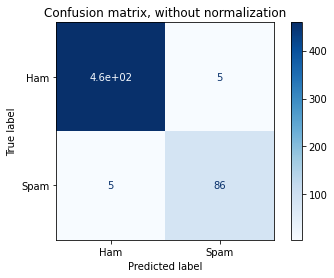

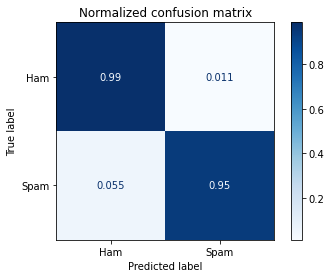

In [18]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
disp = None
for title, normalize in titles_options:
  disp = plot_confusion_matrix(best_model, input, y_test,
                                display_labels=['Ham', 'Spam'],
                                cmap=plt.cm.Blues,
                                normalize=normalize)
  disp.ax_.set_title(title)

  print(title)
  print(disp.confusion_matrix)
plt.show()

In [16]:
predicted = best_model.predict(input)
df = pd.DataFrame()
df['Predicted'] = predicted
df['Actual'] = y_test.values
FP = df[(df['Predicted']==1) & (df['Actual']==0)] # Predict spam, actually ham
FN = df[(df['Predicted']==0) & (df['Actual']==1)] # Predict ham, actually spam

for message in x_train.iloc[FP.index]['Body']:
  print(message)
  print('*********************************************************************************************************')

    Date:        Fri, 23 Aug 2002 02:05:19 +0700
    From:        Robert Elz <kre@munnari.oz.au>
    Message-ID:  <16323.1030043119@munnari.OZ.AU>

When I said ...

  | This is from today's cvs

that will translate as  "yesterday's" now of course (before the most
recent set of changes (catchup speedups, and so on)).

kre



_______________________________________________
Exmh-workers mailing list
Exmh-workers@redhat.com
https://listman.redhat.com/mailman/listinfo/exmh-workers


*********************************************************************************************************
http://www.hughes-family.org/bugzilla/show_bug.cgi?id=1006





------- Additional Comments From spamassassin-contrib@msquadrat.de  2002-10-03 13:57 -------
A solution could be the preprocessor in combination with PM_FILTER -- if we 
get the ExtUtils::MakeMaker versioning stuff right (see bug 1046). 



------- You are receiving this mail because: -------
You are the assignee for the bug, or are watching the

Among the five hams misclassified as spam, one is actually spam misclassified as ham misclassified as spam!

Let's now take a look at the false negatives (spam that looks like ham):

In [17]:
for message in x_train.iloc[FN.index]['Body']:
  print(message)
  print('*********************************************************************************************************')

URL: http://www.askbjoernhansen.com/archives/2002/09/20.html
Date: 2002-09-20T16:13:37-08:00

Jeremy writes about people who ignore basic language rules I entirely agree 
with him. Writing "how r u 2day." is the best way to make me shift my attention 
and respect away from you really fast. Another pet peeve: I have only been 
speaking English on a regular basis for a bit more than three years, and even I 
can grok the difference between "you are" and "your". As mjd wrote on clpm and 
said in the YAPC movie: "You...



*********************************************************************************************************
| 
| 0 hits here. :(
| 

I also get a lot of them. I think they're using the domain registry
database to pull their victims' addresses. 



-------------------------------------------------------
This sf.net email is sponsored by: Jabber - The world's fastest growing 
real-time communications platform! Don't just IM. Build it in! 
http://www.jabber.com/osdn/xim
______

Once again, in fact the data set is polluted! Of these, two are people *discussing* spam, but not actually spamming, one is someone complaining about a colleague's informal spelling, one seems to be a perfectly normal email, and *only one* of our false negatives is actual spam, not the result of ground truth error! Out of over 500 test samples I think we did pretty good. We made the same number of errors as *ground truth itself.*

That's all folks. If you want an encore, you can check out the unfinished pytorch/BERT below. I'd love to get it working but sometimes you just gotta ship.

In [ ]:
!pip install sentence_transformers
device = "cuda:0"
from transformers import BertTokenizer, BertForSequenceClassification

from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained("bert-base-uncased")
import numpy as np
from pdb import set_trace
import math

def apply_bert(text):
  text = text[:min(512, len(text))]
  inputs = tokenizer(text, return_tensors="pt")
  labels = torch.tensor([label]).unsqueeze(0).long()  # Batch size 1
  outputs = bert_model(inputs)['pooler_output']
  return outputs

output = []
for i in range(len(x_train)):
  text = x_train['Body'].iloc[i]
  print(i)
  label = y_train.iloc[i]
  output.append(apply_bert(text))
print(output)


In [ ]:
%debug

BERT & Pytorch

In [ ]:
device = "cuda:0"

from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained("bert-base-uncased")
import numpy as np
from pdb import set_trace
import math

# Input: string pd series
# Output: Bert vectorization of input strings
def multi_apply_bert(input):
  input = list(input.values)
  encoded_inputs = tokenizer(input, return_tensors='pt', padding=True, truncation=True) #
  outputs = bert_model(**encoded_inputs)
  return outputs

def tokenize_with_bert(input):
  full_input = list(input.values)
  n = len(input)
  #MAX_CHUNK_LEN = 10
  #chunks = math.ceil(n / MAX_CHUNK_LEN)
  outputs = torch.zeros(n, 512)
  
  for i, text in enumerate(full_input):
    #start = i*MAX_CHUNK_LEN
    #end = min((i+1)*MAX_CHUNK_LEN, len(input))
    tokenized_text = tokenizer.encode(text, return_tensors='pt', padding=True, truncation=True)
    outputs[i, :tokenized_text.shape[1]] = tokenized_text

  return outputs

bert_tokens = tokenize_with_bert(x_train.iloc[:10]['Body']).long()
print('done tokenizing')

def vectorize_with_bert(input):
  n=len(input)
  outputs = torch.zeros(n, 768)
  for i, x in enumerate(input):
    bert_vector = bert_model(x.unsqueeze(0))
    outputs[i, :] = bert_vector['pooler_output']
  return outputs

print(bert_tokens.shape)
bert_vectors = vectorize_with_bert(bert_tokens)
#outputs.append(bert_model(**encoded_inputs))
#print(bert_vectors.shape)
#set_trace()
pass
#print(applied_bert)

In [ ]:
%debug

In [ ]:
#from coutils import fix_random_seed
#fix_random_seed(0)
from torch import nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data


learning_rate = 1e-2
momentum = 0.5
batch_size = 16

model = nn.Sequential( nn.Linear(768, 128),
                       nn.ReLU(),
                       nn.Linear(128, 2),
                       nn.ReLU(),
                     )
optimizer = optim.SGD(model.parameters(), lr = learning_rate, weight_decay= 1e-4, momentum = 0.5, nesterov = True)

test_bert = apply_bert("what up my homies")
print(test_bert.shape)

model(test_bert)

'''
x_train_dataloader = DataLoader(x_train, batch_size=batch_size, shuffle=True)
y_train_dataloader = DataLoader(y_train, batch_size=batch_size, shuffle=True)
for t, x in enumerate(x_train_dataloader):
  print(t, x)'''

train_tensor = torch.utils.data.TensorDataset(x_train, y_train)
print(train_tensor)

# TODO: score the model
def score_nn(x, y):
  pass

# TODO: convert to batch processing
'''
def train_nn(x_train, y_train):
  i=0
  for x, y in zip(list(x_train), list(y_train)):
    optimizer.zero_grad()
    output = model(apply_bert(x)).unsqueeze(0)
    y = torch.tensor(y).unsqueeze(0).long()
    loss = F.cross_entropy(output, y)
    print(loss)
    loss.backward()
    optimizer.step()

train_nn(x_train_dataloader, y_train_dataloader)'''

In [ ]:
%debug